<a href="https://colab.research.google.com/github/rromerov/Proyecto_Integrador/blob/main/Demo/Demo.12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instituto Tecnológico y de Estudios Superiores de Monterrey
## Maestría en Inteligencia Artificial Aplicada
### Proyecto Integrador (Gpo 10) - TC5035.10

### **Proyecto: Diseño Acelerado de Fármacos**

### Avance 5: Modelo Final

#### **Docentes:**
- Dra. Grettel Barceló Alonso - Profesor Titular
- Dr. Luis Eduardo Falcón Morales - Profesor Titular
- Dr. Ricardo Ambrocio Ramírez Mendoza  – Profesor Tutor

#### **Miembros del equipo:**
- Ernesto Enríquez Rubio - A01228409
- Roberto Romero Vielma - A00822314
- Herbert Joadan Romero Villarreal –  A01794199



---


## Demo
### Resumen de la demostración:

Esta demostración consiste en la recopilación de moléculas SMILES que no han sido utilizadas (vistas) ni por el modelo de regresión ni por el modelo pre-entrenado con finetuning. Esta recopilación de moléculas incluye SMILES que han demostrado cierta bioactividad para la inhibición de la proteína VEGF en general.

El procedimiento es el siguiete:

1.   Recopilación de nuevos SMILES
2.   Generar nuevas moléculas con marcadores comodín para esos SMILES
3.   Filtrado de moléculas válidas con RDKIT
4.   Conversión de moléculas SMILE modificadas a columnas binarias con PaDEL Descriptor
5.   Predicción de pIC50 estandarizado Min-Max para esas moléculas modificadas
6.   Transformación a valores pIC50 sin estandarización
7.   Comparación de pIC50 original y el pIC50 del SMILE modificado
8.   Visualización y graficación para apreciación de diferencias en la molécula





---

## Código de la demostración

Se importan las librerías necesarias y se instalan los paquetes de Python

In [1]:
%%capture
# Instalar librerias
! pip install datasets
! pip install transformers[torch]
! pip install accelerate -U
! pip install rdkit
! pip install rdkit-pypi
! pip install scikit-optimize

# Librería para búsqueda de nombre de moléculas
! pip install chembl_webresource_client

# Librería para búsqueda de nuevas moléculas con PubChem
! pip install beautifulsoup4 requests

In [2]:
# Importar librerías necesarias

# Librerías básicas
import pandas as pd
import numpy as np
from random import sample
import re
import sys
import os
import warnings
import time

# Librerías SKLearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

from sklearn.exceptions import ConvergenceWarning

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import MinMaxScaler

# Libreria para procesamiento paralelo
import joblib
from joblib import Parallel, delayed, parallel_backend, parallel_config

# Libreria para desplegar numero de CPUs Colab
import multiprocessing as mp

# SK Librerías optimización
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize

# Librerías para graficar
import seaborn as sns
import matplotlib.pyplot as plt

# Librerías modelo para modelo MLM
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, RobertaForCausalLM, pipeline
from datasets import Dataset
import torch

# Librerías para trabajar con canonical smiles
from rdkit.Chem import rdchem
from rdkit import Chem
from rdkit.Chem import Draw
from PIL import Image
import difflib

# Librerías Colab
from google.colab import data_table, drive

# Chembl Client
from chembl_webresource_client.new_client import new_client

# PubChem
import requests
from bs4 import BeautifulSoup

### 1. Recopilación de nuevos SMILES

In [121]:
# Lista de CIDs obtenidos manualmente de PubChem
cids = [5329468, 6419834, 5329155, 9797919, 9549295, 5329098, 135433815, 1401]  # Ejemplo de CIDs; reemplázalos con los obtenidos manualmente

In [122]:
# Función para obtener SMILES y valores IC50 de una lista de CIDs de PubChem
def get_smiles_and_ic50_from_cids(cids):
    data_list = []
    for cid in cids:
        url_smiles = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/CanonicalSMILES/JSON"
        url_bio = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/assaysummary/JSON"

        response_smiles = requests.get(url_smiles)
        response_bio = requests.get(url_bio)

        if response_smiles.status_code != 200 or response_bio.status_code != 200:
            continue

        smiles_data = response_smiles.json()
        bio_data = response_bio.json()

        properties = smiles_data.get('PropertyTable', {}).get('Properties', [])
        smiles = 'Unknown'
        for prop in properties:
            smiles = prop.get('CanonicalSMILES', 'Unknown')

        # Inicializar valor de IC50
        ic50 = 'Unknown'

        # Buscar valores de IC50 en los datos de bioactividad
        rows = bio_data.get('Table', {}).get('Row', [])
        for row in rows:
            cells = row.get('Cell', [])
            for i in range(len(cells)):
                if cells[i] == 'IC50':
                    ic50_value = cells[i - 1]
                    try:
                        ic50 = float(ic50_value)
                    except ValueError:
                        continue
                    break
            if ic50 != 'Unknown':
                break

        data_list.append({'CID': cid, 'canonical_smiles': smiles, 'IC50': ic50})

    return data_list

In [123]:
# Obtener los SMILES y valores IC50/pIC50 para los CIDs obtenidos
compound_data = get_smiles_and_ic50_from_cids(cids)

In [124]:
# Crear un DataFrame con los resultados
df_compounds = pd.DataFrame(compound_data)
df_compounds

,CID,canonical_smiles,IC50
0,5329468,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,0.387
1,6419834,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,100.000
2,5329155,C1CCC2=C(C1)C=C(N2)C=C3C4=C(C=CC(=C4)Br)NC3=O,100.000
3,9797919,C1=CC=C(C(=C1)C(=O)NC2=CC=C(C=C2)Cl)NCC3=CC=NC=C3,10.000
4,9549295,CCCNC(=O)NC1=C(C=C(C=C1)OC2=NC=NC3=CC(=C(C=C32...,0.160
5,5329098,CC1=CC(=C(N1)C=C2C3=CC=CC=C3NC2=O)C,0.084
6,135433815,C1=CC=C2C(=C1)C(=C(C(=O)N2)C3=NC4=CC=CC=C4N3)O,0.162
7,1401,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,20.000


In [125]:
# Función para normalizar IC50
def norm_value(input):
    # lista para guardar valores normalizados
    norm = []

    for i in input['IC50']:
        # valores mayores a 100000000 se quedan en 100000000
        if i > 100000000:
          i = 100000000
        # agregarlos a la lista
        norm.append(i)

    # nueva columna con valores estándar normalizados
    input['IC50_norm'] = norm
    # eliminar columna con los datos sin normalizar
    x = input.drop(columns='IC50')

    return x

In [126]:
# Función para obtener el pIC50
def pIC50(input):
  pIC50 = []
  for i in input['IC50_norm']:
    molar = i*(10**-9) # Convierte nM a M
    pIC50.append(-np.log10(molar))

  input['pIC50'] = pIC50
  x = input.drop(columns='IC50_norm')
  return x

In [127]:
# Normalizamos
df_compounds = norm_value(df_compounds)
df_compounds

,CID,canonical_smiles,IC50_norm
0,5329468,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,0.387
1,6419834,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,100.000
2,5329155,C1CCC2=C(C1)C=C(N2)C=C3C4=C(C=CC(=C4)Br)NC3=O,100.000
3,9797919,C1=CC=C(C(=C1)C(=O)NC2=CC=C(C=C2)Cl)NCC3=CC=NC=C3,10.000
4,9549295,CCCNC(=O)NC1=C(C=C(C=C1)OC2=NC=NC3=CC(=C(C=C32...,0.160
5,5329098,CC1=CC(=C(N1)C=C2C3=CC=CC=C3NC2=O)C,0.084
6,135433815,C1=CC=C2C(=C1)C(=C(C(=O)N2)C3=NC4=CC=CC=C4N3)O,0.162
7,1401,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,20.000


In [128]:
# Generamos pIC50
df_compounds = pIC50(df_compounds)
df_compounds

,CID,canonical_smiles,pIC50
0,5329468,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,9.412289
1,6419834,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,7.000000
2,5329155,C1CCC2=C(C1)C=C(N2)C=C3C4=C(C=CC(=C4)Br)NC3=O,7.000000
3,9797919,C1=CC=C(C(=C1)C(=O)NC2=CC=C(C=C2)Cl)NCC3=CC=NC=C3,8.000000
4,9549295,CCCNC(=O)NC1=C(C=C(C=C1)OC2=NC=NC3=CC(=C(C=C32...,9.795880
5,5329098,CC1=CC(=C(N1)C=C2C3=CC=CC=C3NC2=O)C,10.075721
6,135433815,C1=CC=C2C(=C1)C(=C(C(=O)N2)C3=NC4=CC=CC=C4N3)O,9.790485
7,1401,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,7.698970


In [129]:
df_compounds.describe()

,CID,pIC50
count,8.000000e+00,8.000000
mean,2.214875e+07,8.596668
std,4.587465e+07,1.308036
min,1.401000e+03,7.000000
25%,5.329141e+06,7.524228
50%,5.874651e+06,8.706145
75%,9.611451e+06,9.791834
max,1.354338e+08,10.075721


### 2. Generar nuevas moléculas con marcadores comodín para esos SMILES


#### Carga del modelo pre-entrenado con finetuning

In [130]:
# Cargar Google Drive al notebook
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [131]:
# Verificar si CUDA está disponible y definir el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device in use: {device}')

Device in use: cpu


In [132]:
# Cargar el modelo y el tokenizador entrenados
model_name = "/content/drive/My Drive/Colab Notebooks/data/results"  # Directorio donde se guardaron los resultados del entrenamiento
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = RobertaForCausalLM.from_pretrained(model_name, is_decoder=True)  # Asegúrate de configurar el modelo como decodificador

# Crear el pipeline de fill-mask usando el modelo afinado
fill_mask = pipeline(
    "fill-mask",
    model=model,
    tokenizer=tokenizer
)

#### 3. Funciones para generación de SMILES

##### Filtrado de moléculas válidas con RDKIT

In [172]:
# Función para validar SMILES
def is_valid_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None

In [173]:
# Función para remover átomos y agregar *
def remove_atoms_and_placeholder(smiles, num_atoms_to_remove=1):
    # Redirigir stderr para silenciar errores de RDKit
    stderr = sys.stderr
    sys.stderr = open(os.devnull, 'w')

    try:
        # Convertir SMILES a una molécula RDKit
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None, None

        # Seleccionar átomos al azar para eliminar
        atoms_to_remove = sample(range(mol.GetNumAtoms()), num_atoms_to_remove)

        # Crear una copia editable de la molécula
        mol_edit = rdchem.RWMol(mol)

        # Remover átomos
        for idx in sorted(atoms_to_remove, reverse=True):
            mol_edit.ReplaceAtom(idx, rdchem.Atom('*'))

        # Convertir la molécula modificada de nuevo a SMILES
        modified_smiles = Chem.MolToSmiles(mol_edit)

    finally:
        # Restaurar stderr
        sys.stderr.close()
        sys.stderr = stderr

    return modified_smiles

In [174]:
%%capture
# Número de veces a ejecutar el generador por cada SMILE
# Tomando en cuenta que por cada vez, se generan 5 smiles modificados
# Pero que no todos son modificaciones atómicas válidas
samples_per_smile = 3

# Ejemplo de múltiples secuencias SMILES con placeholders en diferentes posiciones
smiles_list = df_compounds['canonical_smiles']

# DataFrame para almacenar los resultados
results_list = []

# Generar secuencias completas para cada SMILES en la lista
for idx, smiles in enumerate(smiles_list):
    modified_smiles_list = []  # Lista para almacenar las secuencias modificadas
    for _ in range(samples_per_smile):  # Ejecutar 5 veces la función remove_atoms_and_placeholder
        modified_smiles = remove_atoms_and_placeholder(smiles, num_atoms_to_remove=1)
        if modified_smiles:
            modified_smiles_list.append(modified_smiles)

    # Procesar cada secuencia modificada obtenida
    for modified_smiles in modified_smiles_list:
        modified_smiles_with_mask = modified_smiles.replace('*', '<mask>')

        # Usar el pipeline para llenar las máscaras
        results = fill_mask(modified_smiles_with_mask)

        # Procesar los resultados y almacenar en la lista de resultados
        for res in results:
            sequence = res['sequence']
            sequence = sequence.replace('<s>', '').replace('</s>', '').strip()
            if is_valid_smiles(sequence):
                results_list.append({
                    'Original_SMILES': smiles,
                    'Modified_SMILES': sequence,
                    'Group': idx
                })

# Crear el DataFrame a partir de la lista de resultados
results_df = pd.DataFrame(results_list)

# Filtrar filas donde el Original_SMILES sea igual al Modified_SMILES
results_df = results_df[results_df['Original_SMILES'] != results_df['Modified_SMILES']]

In [175]:
# Mostrar el DataFrame resultante
results_df = results_df.reset_index(drop=True)
results_df

,Original_SMILES,Modified_SMILES,Group
0,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COc1ccc(-c2cnc3c(-c4c:CCCC:cc4)cnn3c2)cc1,0
1,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COc1ccc(-c2cnc3c(-c4c:nccn:cc4)cnn3c2)cc1,0
2,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COc1ccc(-c2:c:n3ncc(-c4ccsc4)c3nc2)cc1,0
3,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COc1ccc(-c2:n:n3ncc(-c4ccsc4)c3nc2)cc1,0
4,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COc1ccc(-c2:cnc:n3ncc(-c4ccsc4)c3nc2)cc1,0
5,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,CCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccc:c:c32)c1C,1
6,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,CCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,1
7,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,CCCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,1
8,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,CCNOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,1
9,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,CCNCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,1


In [176]:
# Seleccionar solo la columna 'CID' del DataFrame original
df_subset = df_compounds[['CID']]

# Añadir la columna 'CID' al DataFrame results_df
merged_df = pd.merge(results_df, df_subset, left_on='Group', right_index=True)

In [177]:
# Mostrar el DataFrame resultante
merged_df = merged_df.reset_index(drop=True)
merged_df

,Original_SMILES,Modified_SMILES,Group,CID
0,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COc1ccc(-c2cnc3c(-c4c:CCCC:cc4)cnn3c2)cc1,0,5329468
1,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COc1ccc(-c2cnc3c(-c4c:nccn:cc4)cnn3c2)cc1,0,5329468
2,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COc1ccc(-c2:c:n3ncc(-c4ccsc4)c3nc2)cc1,0,5329468
3,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COc1ccc(-c2:n:n3ncc(-c4ccsc4)c3nc2)cc1,0,5329468
4,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COc1ccc(-c2:cnc:n3ncc(-c4ccsc4)c3nc2)cc1,0,5329468
5,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,CCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccc:c:c32)c1C,1,6419834
6,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,CCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,1,6419834
7,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,CCCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,1,6419834
8,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,CCNOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,1,6419834
9,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,CCNCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,1,6419834


In [178]:
# Remover moléculas modificadas que sean iguales a las originales
merged_df = merged_df[merged_df['Original_SMILES'] != merged_df['Modified_SMILES']]
merged_df

,Original_SMILES,Modified_SMILES,Group,CID
0,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COc1ccc(-c2cnc3c(-c4c:CCCC:cc4)cnn3c2)cc1,0,5329468
1,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COc1ccc(-c2cnc3c(-c4c:nccn:cc4)cnn3c2)cc1,0,5329468
2,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COc1ccc(-c2:c:n3ncc(-c4ccsc4)c3nc2)cc1,0,5329468
3,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COc1ccc(-c2:n:n3ncc(-c4ccsc4)c3nc2)cc1,0,5329468
4,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COc1ccc(-c2:cnc:n3ncc(-c4ccsc4)c3nc2)cc1,0,5329468
5,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,CCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccc:c:c32)c1C,1,6419834
6,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,CCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,1,6419834
7,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,CCCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,1,6419834
8,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,CCNOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,1,6419834
9,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,CCNCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,1,6419834


In [179]:
# Eliminar filas duplicadas basadas en la columna 'Modified_SMILES'
merged_df = merged_df.drop_duplicates(subset='Modified_SMILES')

# Mostrar el DataFrame resultante
merged_df

,Original_SMILES,Modified_SMILES,Group,CID
0,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COc1ccc(-c2cnc3c(-c4c:CCCC:cc4)cnn3c2)cc1,0,5329468
1,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COc1ccc(-c2cnc3c(-c4c:nccn:cc4)cnn3c2)cc1,0,5329468
2,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COc1ccc(-c2:c:n3ncc(-c4ccsc4)c3nc2)cc1,0,5329468
3,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COc1ccc(-c2:n:n3ncc(-c4ccsc4)c3nc2)cc1,0,5329468
4,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COc1ccc(-c2:cnc:n3ncc(-c4ccsc4)c3nc2)cc1,0,5329468
5,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,CCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccc:c:c32)c1C,1,6419834
6,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,CCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,1,6419834
7,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,CCCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,1,6419834
8,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,CCNOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,1,6419834
9,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,CCNCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,1,6419834


In [180]:
# Agregar identificador para las nuevas moléculas usando .loc
merged_df.loc[:, 'molecule_id'] = range(1, len(merged_df) + 1)

In [181]:
# Guardamos el DataFrame con la lista de todos los Modified_SMILES válidos
merged_df.to_csv('/content/drive/My Drive/Colab Notebooks/data/bioactivity_data_new_molecules_demo.csv', index=False)
merged_df.to_csv('./bioactivity_data_new_molecules_demo.csv', index=False)

In [182]:
# Cargar CSV
merged_df = pd.read_csv('./bioactivity_data_new_molecules_demo.csv')

In [183]:
# Mostrar df
merged_df

,Original_SMILES,Modified_SMILES,Group,CID,molecule_id
0,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COc1ccc(-c2cnc3c(-c4c:CCCC:cc4)cnn3c2)cc1,0,5329468,1
1,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COc1ccc(-c2cnc3c(-c4c:nccn:cc4)cnn3c2)cc1,0,5329468,2
2,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COc1ccc(-c2:c:n3ncc(-c4ccsc4)c3nc2)cc1,0,5329468,3
3,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COc1ccc(-c2:n:n3ncc(-c4ccsc4)c3nc2)cc1,0,5329468,4
4,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COc1ccc(-c2:cnc:n3ncc(-c4ccsc4)c3nc2)cc1,0,5329468,5
5,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,CCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccc:c:c32)c1C,1,6419834,6
6,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,CCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,1,6419834,7
7,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,CCCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,1,6419834,8
8,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,CCNOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,1,6419834,9
9,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,CCNCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,1,6419834,10


### 4. Conversión de moléculas SMILE con PaDEL Descriptor

In [184]:
# Columnas de interés para el descriptor PADEL
columnas = ['Modified_SMILES','molecule_id']
df_selection = merged_df[columnas]
df_selection

,Modified_SMILES,molecule_id
0,COc1ccc(-c2cnc3c(-c4c:CCCC:cc4)cnn3c2)cc1,1
1,COc1ccc(-c2cnc3c(-c4c:nccn:cc4)cnn3c2)cc1,2
2,COc1ccc(-c2:c:n3ncc(-c4ccsc4)c3nc2)cc1,3
3,COc1ccc(-c2:n:n3ncc(-c4ccsc4)c3nc2)cc1,4
4,COc1ccc(-c2:cnc:n3ncc(-c4ccsc4)c3nc2)cc1,5
5,CCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccc:c:c32)c1C,6
6,CCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,7
7,CCCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,8
8,CCNOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,9
9,CCNCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,10


In [185]:
# Guardar en un archivo SMI
# En drive
df_selection.to_csv('/content/drive/My Drive/Colab Notebooks/data/new_molecule_demo.smi', sep='\t', index=False, header=False)
# Local
df_selection.to_csv('new_molecule.smi', sep='\t', index=False, header=False)

In [186]:
# Visualizar las moleculas guardadas
! cat '/content/drive/My Drive/Colab Notebooks/data/new_molecule_demo.smi' | head -5

COc1ccc(-c2cnc3c(-c4c:CCCC:cc4)cnn3c2)cc1	1
COc1ccc(-c2cnc3c(-c4c:nccn:cc4)cnn3c2)cc1	2
COc1ccc(-c2:c:n3ncc(-c4ccsc4)c3nc2)cc1	3
COc1ccc(-c2:n:n3ncc(-c4ccsc4)c3nc2)cc1	4
COc1ccc(-c2:cnc:n3ncc(-c4ccsc4)c3nc2)cc1	5


In [187]:
# Número de registros
! cat '/content/drive/My Drive/Colab Notebooks/data/new_molecule_demo.smi' | wc -l

41


**Cálculo de descriptores con PaDEL**


In [188]:
%%capture
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

!cp -rf "padel.zip" "/content/drive/My Drive/Colab Notebooks/data/padel.zip"
!cp -rf "padel.sh" "/content/drive/My Drive/Colab Notebooks/data/padel.sh"

!cp -rf "/content/drive/My Drive/Colab Notebooks/data/padel.zip" "padel.zip"
!cp -rf "/content/drive/My Drive/Colab Notebooks/data/padel.sh" "padel.sh"

In [189]:
# Descomprimimos padel sin Output en consola
%%capture
! unzip -o padel.zip

In [190]:
# Inspeccionamos el script de PaDEL que nos ayudará a generar los descriptores
! cat padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


In [191]:
# Calculamos los descriptores con PaDEL sin Output en consola
%%capture
! bash padel.sh

In [192]:
# Guardamos el output como csv
!cp -rf "descriptors_output.csv" "/content/drive/My Drive/Colab Notebooks/data/descriptors_output_new_mol_demo.csv"

In [193]:
# Mostrar descriptores calculados con Padel
fingerprints_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/descriptors_output_new_mol_demo.csv')
fingerprints_df

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,8,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,9,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,10,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [194]:
# Guardar en drive el dataset
fingerprints_df.to_csv('/content/drive/My Drive/Colab Notebooks/data/pubchem_fp_new_mol_demo.csv', index=False)

### 5. Predicción de pIC50 estandarizado Min-Max para esas moléculas modificadas

In [195]:
# Usar nuevo dataset
df_new_mol = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/pubchem_fp_new_mol_demo.csv')
df_new_mol

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,8,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,9,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,10,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [196]:
# Se define conjunto X_new_mol para los fingerprints de las nuevas moléculas
X_new_mol = df_new_mol.drop('Name', axis=1)
# Mostrar contenido en el conjunto de X_new_mol
X_new_mol

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


##### **Nuevas moléculas con mejor pIC50**

In [197]:
# Cargar el modelo desde el archivo
stacking_model = joblib.load('/content/drive/My Drive/Colab Notebooks/data/stacking_model.pkl')

# Usar el modelo para hacer predicciones
Y_pred_new_mol = stacking_model.predict(X_new_mol)

In [198]:
# Obtener las posiciones de las 10 predicciones más altas
top_10_indices = Y_pred_new_mol.argsort()[-10:][::-1]

# Obtener los nombres (Name) de estas moléculas
top_10_names = df_new_mol.iloc[top_10_indices]['Name'].values

# Filtrar fingerprints_df para obtener molecule_id
top_10_ids = fingerprints_df[fingerprints_df['Name'].isin(top_10_names)]

# Unir con df_selection para obtener las SMILES canónicas
top_10_smiles = df_selection[df_selection['molecule_id'].isin(top_10_ids['Name'])]

# Unir los resultados para tener un dataframe con SMILES y pIC50
result = top_10_smiles.merge(top_10_ids, left_on='molecule_id', right_on='Name')
result['pIC50'] = Y_pred_new_mol[top_10_indices]

# Seleccionar las columnas de interés
result = result[['Modified_SMILES', 'pIC50']]

# Mostrar las primeras 10 moléculas con mayor pIC50 y sus SMILES
result


,Modified_SMILES,pIC50
0,COc1ccc(-c2:c:n3ncc(-c4ccsc4)c3nc2)cc1,0.646188
1,COc1ccc(-c2:cnc:n3ncc(-c4ccsc4)c3nc2)cc1,0.608965
2,CCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccc:c:c32)c1C,0.594700
3,CCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,0.547264
4,CCCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,0.547264
5,CCCCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,0.547264
6,CCCCNC(=O)Nc1ccc(Oc2ncnc3cc(OC)c(OC)cc23)cc1Cl,0.547264
7,CCCNC(=O)Nc1ccc(Oc2ncnc3cc(OC)c(OC)cc23)cc1Cl,0.540633
8,O=c1[nH]c2ccccc2c(O)c1-c1:c:c2ccccc2[nH]1,0.540084
9,CCN(CC)CCCCNc1:c:cc2cc(-c3cc(OC)cc(OC)c3)c(NC(...,0.540084


In [199]:
# Exportar a csv el dataset
result.to_csv('/content/drive/My Drive/Colab Notebooks/data/new_molecule_pIC50_demo.csv', index=False)

In [200]:
# Guardar archivos en un archivo zip
! zip -r /content/drive/My\ Drive/Colab\ Notebooks/data/results_demo.zip /content/drive/My\ Drive/Colab\ Notebooks/data

updating: content/drive/My Drive/Colab Notebooks/data/ (stored 0%)
updating: content/drive/My Drive/Colab Notebooks/data/results/ (stored 0%)
updating: content/drive/My Drive/Colab Notebooks/data/results/tokenizer_config.json (deflated 76%)
updating: content/drive/My Drive/Colab Notebooks/data/results/special_tokens_map.json (deflated 84%)
updating: content/drive/My Drive/Colab Notebooks/data/results/config.json (deflated 48%)
updating: content/drive/My Drive/Colab Notebooks/data/results/tokenizer.json (deflated 79%)
updating: content/drive/My Drive/Colab Notebooks/data/results/merges.txt (deflated 71%)
updating: content/drive/My Drive/Colab Notebooks/data/results/vocab.json (deflated 67%)
updating: content/drive/My Drive/Colab Notebooks/data/results/generation_config.json (deflated 29%)
updating: content/drive/My Drive/Colab Notebooks/data/results/model.safetensors (deflated 7%)
updating: content/drive/My Drive/Colab Notebooks/data/bioactivity_data_3class_pIC50_pubchem_fp.csv (deflate



---

### Comparación moléculas modificadas vs moléculas originales





In [201]:
# Cargar el dataset
ruta_archivo_modified_molecules = '/content/drive/My Drive/Colab Notebooks/data/new_molecule_pIC50_demo.csv'

# Lee el archivo CSV en un DataFrame
df_modified_molecules = pd.read_csv(ruta_archivo_modified_molecules)

# Mostrar que se haya importado correctamente el archivo
df_modified_molecules

,Modified_SMILES,pIC50
0,COc1ccc(-c2:c:n3ncc(-c4ccsc4)c3nc2)cc1,0.646188
1,COc1ccc(-c2:cnc:n3ncc(-c4ccsc4)c3nc2)cc1,0.608965
2,CCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccc:c:c32)c1C,0.594700
3,CCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,0.547264
4,CCCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,0.547264
5,CCCCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,0.547264
6,CCCCNC(=O)Nc1ccc(Oc2ncnc3cc(OC)c(OC)cc23)cc1Cl,0.547264
7,CCCNC(=O)Nc1ccc(Oc2ncnc3cc(OC)c(OC)cc23)cc1Cl,0.540633
8,O=c1[nH]c2ccccc2c(O)c1-c1:c:c2ccccc2[nH]1,0.540084
9,CCN(CC)CCCCNc1:c:cc2cc(-c3cc(OC)cc(OC)c3)c(NC(...,0.540084


In [202]:
# Cargar el dataset
ruta_archivo_new_molecules = '/content/drive/My Drive/Colab Notebooks/data/bioactivity_data_new_molecules_demo.csv'

# Lee el archivo CSV en un DataFrame
df_new_molecules = pd.read_csv(ruta_archivo_new_molecules)

# Mostrar que se haya importado correctamente el archivo
df_new_molecules

,Original_SMILES,Modified_SMILES,Group,CID,molecule_id
0,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COc1ccc(-c2cnc3c(-c4c:CCCC:cc4)cnn3c2)cc1,0,5329468,1
1,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COc1ccc(-c2cnc3c(-c4c:nccn:cc4)cnn3c2)cc1,0,5329468,2
2,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COc1ccc(-c2:c:n3ncc(-c4ccsc4)c3nc2)cc1,0,5329468,3
3,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COc1ccc(-c2:n:n3ncc(-c4ccsc4)c3nc2)cc1,0,5329468,4
4,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COc1ccc(-c2:cnc:n3ncc(-c4ccsc4)c3nc2)cc1,0,5329468,5
5,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,CCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccc:c:c32)c1C,1,6419834,6
6,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,CCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,1,6419834,7
7,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,CCCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,1,6419834,8
8,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,CCNOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,1,6419834,9
9,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,CCNCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,1,6419834,10


In [203]:
# Asegurarse de que ambos DataFrames tienen la columna 'Modified_SMILES' para realizar la fusión
# Fusionar los DataFrames usando 'Modified_SMILES' como clave
merged_df_original_modified = pd.merge(df_modified_molecules, df_new_molecules[['Modified_SMILES', 'Original_SMILES', 'CID']], on='Modified_SMILES', how='inner')

# Renombrar la columna 'pIC50' a 'Predicted_pIC50'
merged_df_original_modified = merged_df_original_modified.rename(columns={'pIC50': 'Predicted_pIC50'})

# Mostrar el DataFrame resultante
merged_df_original_modified

,Modified_SMILES,Predicted_pIC50,Original_SMILES,CID
0,COc1ccc(-c2:c:n3ncc(-c4ccsc4)c3nc2)cc1,0.646188,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468
1,COc1ccc(-c2:cnc:n3ncc(-c4ccsc4)c3nc2)cc1,0.608965,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468
2,CCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccc:c:c32)c1C,0.594700,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,6419834
3,CCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,0.547264,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,6419834
4,CCCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,0.547264,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,6419834
5,CCCCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,0.547264,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,6419834
6,CCCCNC(=O)Nc1ccc(Oc2ncnc3cc(OC)c(OC)cc23)cc1Cl,0.547264,CCCNC(=O)NC1=C(C=C(C=C1)OC2=NC=NC3=CC(=C(C=C32...,9549295
7,CCCNC(=O)Nc1ccc(Oc2ncnc3cc(OC)c(OC)cc23)cc1Cl,0.540633,CCCNC(=O)NC1=C(C=C(C=C1)OC2=NC=NC3=CC(=C(C=C32...,9549295
8,O=c1[nH]c2ccccc2c(O)c1-c1:c:c2ccccc2[nH]1,0.540084,C1=CC=C2C(=C1)C(=C(C(=O)N2)C3=NC4=CC=CC=C4N3)O,135433815
9,CCN(CC)CCCCNc1:c:cc2cc(-c3cc(OC)cc(OC)c3)c(NC(...,0.540084,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,1401


In [204]:
# Supongamos que estos eran los valores mínimo y máximo originales de pIC50
min_pIC50 = 7  # Reemplaza con el valor mínimo original de pIC50
max_pIC50 = 10.075721 # Reemplaza con el valor máximo original de pIC50

# Función para desescalar manualmente
def invert_scaling(scaled_value, min_val, max_val):
    return scaled_value * (max_val - min_val) + min_val

# Aplicar la función de desescalado manualmente
merged_df_original_modified['Predicted_pIC50'] = merged_df_original_modified['Predicted_pIC50'].apply(invert_scaling, args=(min_pIC50, max_pIC50))

merged_df_original_modified

,Modified_SMILES,Predicted_pIC50,Original_SMILES,CID
0,COc1ccc(-c2:c:n3ncc(-c4ccsc4)c3nc2)cc1,8.987495,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468
1,COc1ccc(-c2:cnc:n3ncc(-c4ccsc4)c3nc2)cc1,8.873006,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468
2,CCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccc:c:c32)c1C,8.829131,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,6419834
3,CCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,8.683230,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,6419834
4,CCCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,8.683230,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,6419834
5,CCCCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,8.683230,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,6419834
6,CCCCNC(=O)Nc1ccc(Oc2ncnc3cc(OC)c(OC)cc23)cc1Cl,8.683230,CCCNC(=O)NC1=C(C=C(C=C1)OC2=NC=NC3=CC(=C(C=C32...,9549295
7,CCCNC(=O)Nc1ccc(Oc2ncnc3cc(OC)c(OC)cc23)cc1Cl,8.662835,CCCNC(=O)NC1=C(C=C(C=C1)OC2=NC=NC3=CC(=C(C=C32...,9549295
8,O=c1[nH]c2ccccc2c(O)c1-c1:c:c2ccccc2[nH]1,8.661147,C1=CC=C2C(=C1)C(=C(C(=O)N2)C3=NC4=CC=CC=C4N3)O,135433815
9,CCN(CC)CCCCNc1:c:cc2cc(-c3cc(OC)cc(OC)c3)c(NC(...,8.661147,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,1401


In [205]:
# Lee el archivo CSV en un DataFrame
df_main_all_pIC50 = df_compounds.copy()

# Mostrar que se haya importado correctamente el archivo
df_main_all_pIC50

,CID,canonical_smiles,pIC50
0,5329468,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,9.412289
1,6419834,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,7.000000
2,5329155,C1CCC2=C(C1)C=C(N2)C=C3C4=C(C=CC(=C4)Br)NC3=O,7.000000
3,9797919,C1=CC=C(C(=C1)C(=O)NC2=CC=C(C=C2)Cl)NCC3=CC=NC=C3,8.000000
4,9549295,CCCNC(=O)NC1=C(C=C(C=C1)OC2=NC=NC3=CC(=C(C=C32...,9.795880
5,5329098,CC1=CC(=C(N1)C=C2C3=CC=CC=C3NC2=O)C,10.075721
6,135433815,C1=CC=C2C(=C1)C(=C(C(=O)N2)C3=NC4=CC=CC=C4N3)O,9.790485
7,1401,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,7.698970


In [206]:
# Fusionar los DataFrames usando 'molecule_chembl_id' como clave
merged_df_original_modified = pd.merge(merged_df_original_modified, df_main_all_pIC50[['CID', 'pIC50']], on='CID', how='left')

# Renombrar la columna 'pIC50' a 'Original_pIC50'
merged_df_original_modified = merged_df_original_modified.rename(columns={'pIC50': 'Original_pIC50'})

# Mostrar el DataFrame resultante
merged_df_original_modified

,Modified_SMILES,Predicted_pIC50,Original_SMILES,CID,Original_pIC50
0,COc1ccc(-c2:c:n3ncc(-c4ccsc4)c3nc2)cc1,8.987495,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468,9.412289
1,COc1ccc(-c2:cnc:n3ncc(-c4ccsc4)c3nc2)cc1,8.873006,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468,9.412289
2,CCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccc:c:c32)c1C,8.829131,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,6419834,7.000000
3,CCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,8.683230,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,6419834,7.000000
4,CCCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,8.683230,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,6419834,7.000000
5,CCCCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,8.683230,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,6419834,7.000000
6,CCCCNC(=O)Nc1ccc(Oc2ncnc3cc(OC)c(OC)cc23)cc1Cl,8.683230,CCCNC(=O)NC1=C(C=C(C=C1)OC2=NC=NC3=CC(=C(C=C32...,9549295,9.795880
7,CCCNC(=O)Nc1ccc(Oc2ncnc3cc(OC)c(OC)cc23)cc1Cl,8.662835,CCCNC(=O)NC1=C(C=C(C=C1)OC2=NC=NC3=CC(=C(C=C32...,9549295,9.795880
8,O=c1[nH]c2ccccc2c(O)c1-c1:c:c2ccccc2[nH]1,8.661147,C1=CC=C2C(=C1)C(=C(C(=O)N2)C3=NC4=CC=CC=C4N3)O,135433815,9.790485
9,CCN(CC)CCCCNc1:c:cc2cc(-c3cc(OC)cc(OC)c3)c(NC(...,8.661147,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,1401,7.698970


In [207]:
# Función para obtener el nombre de la molécula a partir del CID de PubChem
def get_molecular_formula(cid):
    try:
        url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/MolecularFormula/JSON"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            formula = data.get('PropertyTable', {}).get('Properties', [{}])[0].get('MolecularFormula', 'Unknown')
            return formula
        else:
            return 'Unknown'
    except:
        return 'Unknown'

# Aplicar la función para obtener las fórmulas moleculares y crear una nueva columna
merged_df_original_modified['Molecular_Formula'] = merged_df_original_modified['CID'].apply(get_molecular_formula)

# Mostrar el DataFrame resultante
merged_df_original_modified

,Modified_SMILES,Predicted_pIC50,Original_SMILES,CID,Original_pIC50,Molecular_Formula
0,COc1ccc(-c2:c:n3ncc(-c4ccsc4)c3nc2)cc1,8.987495,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468,9.412289,C17H13N3OS
1,COc1ccc(-c2:cnc:n3ncc(-c4ccsc4)c3nc2)cc1,8.873006,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468,9.412289,C17H13N3OS
2,CCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccc:c:c32)c1C,8.829131,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,6419834,7.000000,C18H18N2O3
3,CCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,8.683230,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,6419834,7.000000,C18H18N2O3
4,CCCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,8.683230,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,6419834,7.000000,C18H18N2O3
5,CCCCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,8.683230,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,6419834,7.000000,C18H18N2O3
6,CCCCNC(=O)Nc1ccc(Oc2ncnc3cc(OC)c(OC)cc23)cc1Cl,8.683230,CCCNC(=O)NC1=C(C=C(C=C1)OC2=NC=NC3=CC(=C(C=C32...,9549295,9.795880,C20H21ClN4O4
7,CCCNC(=O)Nc1ccc(Oc2ncnc3cc(OC)c(OC)cc23)cc1Cl,8.662835,CCCNC(=O)NC1=C(C=C(C=C1)OC2=NC=NC3=CC(=C(C=C32...,9549295,9.795880,C20H21ClN4O4
8,O=c1[nH]c2ccccc2c(O)c1-c1:c:c2ccccc2[nH]1,8.661147,C1=CC=C2C(=C1)C(=C(C(=O)N2)C3=NC4=CC=CC=C4N3)O,135433815,9.790485,C16H11N3O2
9,CCN(CC)CCCCNc1:c:cc2cc(-c3cc(OC)cc(OC)c3)c(NC(...,8.661147,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,1401,7.698970,C28H41N7O3


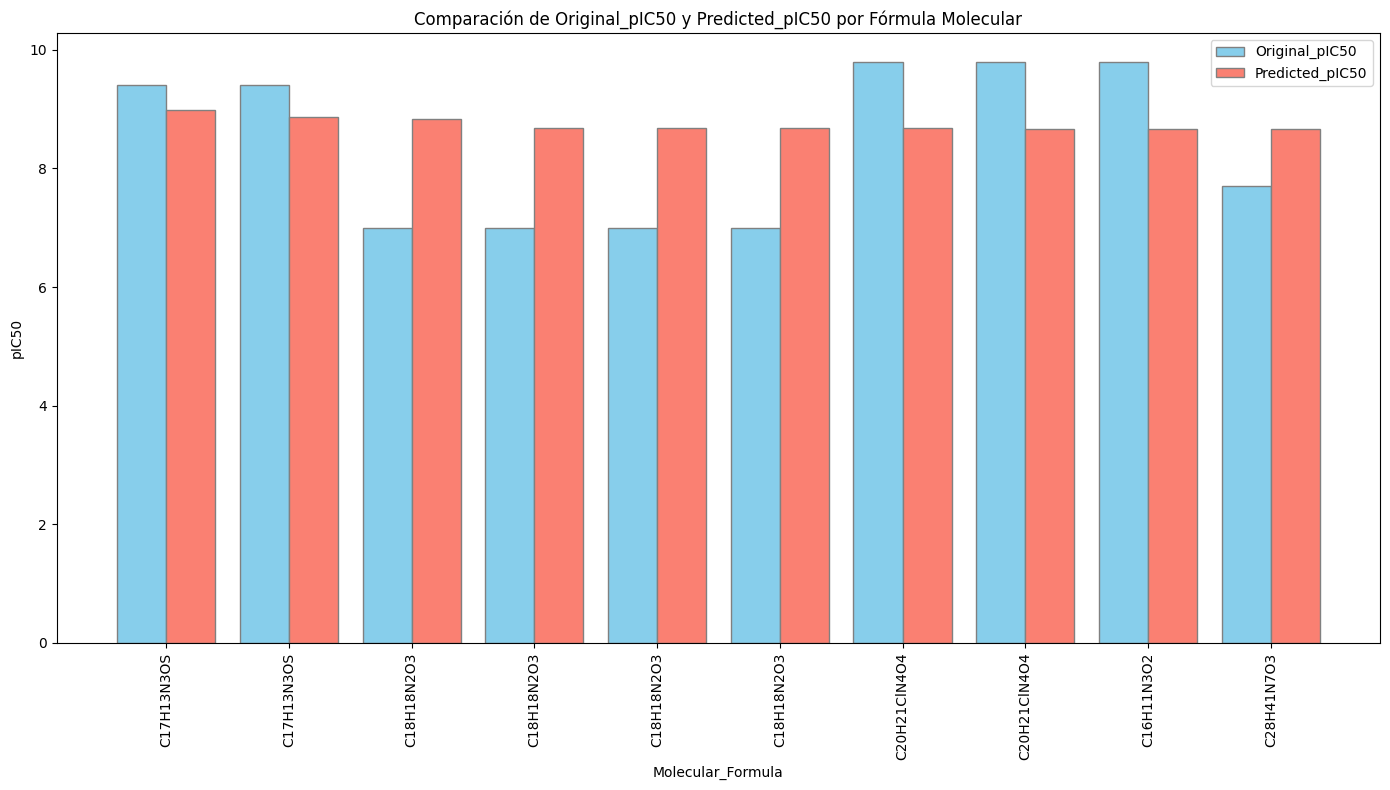

In [208]:
# Crear una figura y un conjunto de ejes
fig, ax = plt.subplots(figsize=(14, 8))

# Definir el ancho de las barras
bar_width = 0.4

# Crear un rango para las posiciones de las barras
r1 = np.arange(len(merged_df_original_modified))
r2 = [x + bar_width for x in r1]

# Crear las barras para Original_pIC50
ax.bar(r1, merged_df_original_modified['Original_pIC50'], color='skyblue', width=bar_width, edgecolor='grey', label='Original_pIC50')

# Crear las barras para Predicted_pIC50
ax.bar(r2, merged_df_original_modified['Predicted_pIC50'], color='salmon', width=bar_width, edgecolor='grey', label='Predicted_pIC50')

# Añadir etiquetas de ejes y título
ax.set_xlabel('Molecular_Formula')
ax.set_ylabel('pIC50')
ax.set_title('Comparación de Original_pIC50 y Predicted_pIC50 por Fórmula Molecular')

# Añadir etiquetas de ticks en el eje x
ax.set_xticks([r + bar_width / 2 for r in range(len(merged_df_original_modified))])
ax.set_xticklabels(merged_df_original_modified['Molecular_Formula'], rotation=90)

# Añadir leyenda
ax.legend()

# Ajustar el diseño
plt.tight_layout()

# Mostrar la gráfica
plt.show()


In [209]:
# Función para obtener las diferencias entre dos strings
def get_differences(original, modified):
    diff = difflib.ndiff(original, modified)
    changes = [d for d in diff if d.startswith('- ') or d.startswith('+ ')]
    return changes

# Aplicar la función para obtener las diferencias y crear una nueva columna
merged_df_original_modified['Differences'] = merged_df_original_modified.apply(
    lambda row: get_differences(row['Original_SMILES'], row['Modified_SMILES']),
    axis=1
)

# Mostrar el DataFrame resultante con las diferencias
merged_df_original_modified[['Original_SMILES', 'Modified_SMILES', 'Differences']]


,Original_SMILES,Modified_SMILES,Differences
0,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COc1ccc(-c2:c:n3ncc(-c4ccsc4)c3nc2)cc1,"[- C, + c, + c, + c, + c, - =, - C, - C, - =, ..."
1,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COc1ccc(-c2:cnc:n3ncc(-c4ccsc4)c3nc2)cc1,"[- C, + c, + c, + c, + c, - =, - C, - C, - =, ..."
2,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,CCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccc:c:c32)c1C,"[- C, + c, + c, - =, - C, - N, - C, - (, - =, ..."
3,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,CCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,"[- C, + c, + c, - =, - C, - N, - C, - (, - =, ..."
4,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,CCCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,"[+ C, - C, + c, + c, - =, - C, - N, - C, - (, ..."
5,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,CCCCOC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccccc32)c1C,"[+ C, + C, - C, + c, + c, - =, - C, - N, - C, ..."
6,CCCNC(=O)NC1=C(C=C(C=C1)OC2=NC=NC3=CC(=C(C=C32...,CCCCNC(=O)Nc1ccc(Oc2ncnc3cc(OC)c(OC)cc23)cc1Cl,"[+ C, - C, + c, - =, - C, + c, + c, + c, - C, ..."
7,CCCNC(=O)NC1=C(C=C(C=C1)OC2=NC=NC3=CC(=C(C=C32...,CCCNC(=O)Nc1ccc(Oc2ncnc3cc(OC)c(OC)cc23)cc1Cl,"[- C, + c, - =, - C, + c, + c, + c, - C, - =, ..."
8,C1=CC=C2C(=C1)C(=C(C(=O)N2)C3=NC4=CC=CC=C4N3)O,O=c1[nH]c2ccccc2c(O)c1-c1:c:c2ccccc2[nH]1,"[- C, + O, + =, + c, - =, - C, - C, - =, - C, ..."
9,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,CCN(CC)CCCCNc1:c:cc2cc(-c3cc(OC)cc(OC)c3)c(NC(...,"[- C, + c, - =, - N, - C, + :, + c, + :, + c, ..."


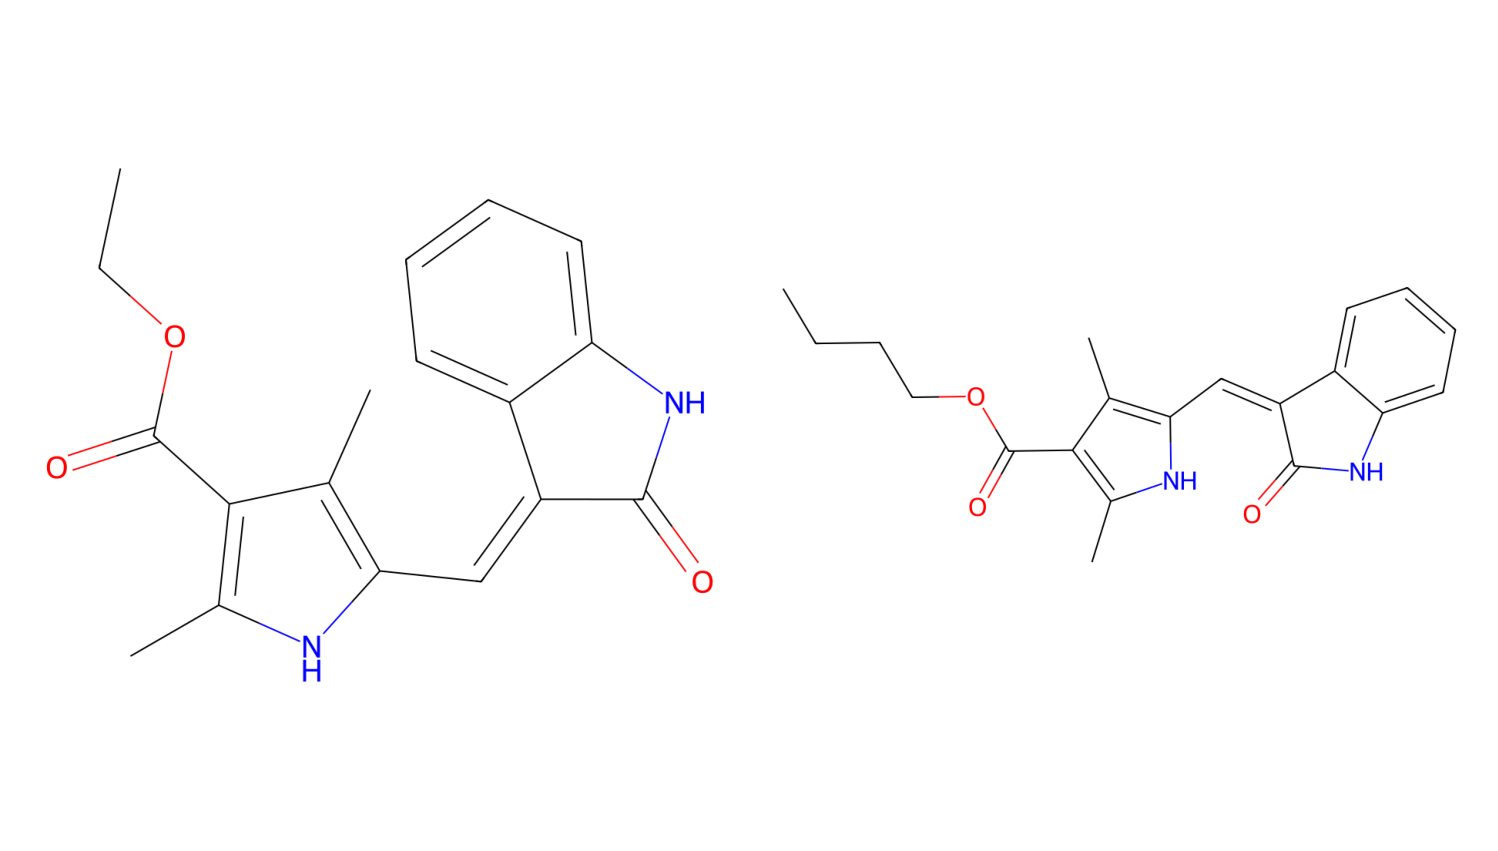

In [212]:
# Función para visualizar moléculas lado a lado usando PIL y matplotlib en calidad Full HD
def visualize_molecules(df, index):
    original_smiles = df.loc[index, 'Original_SMILES']
    modified_smiles = df.loc[index, 'Modified_SMILES']

    original_mol = Chem.MolFromSmiles(original_smiles)
    modified_mol = Chem.MolFromSmiles(modified_smiles)

    original_img = Draw.MolToImage(original_mol, size=(960, 1080))
    modified_img = Draw.MolToImage(modified_mol, size=(960, 1080))

    # Crear una nueva imagen en blanco lo suficientemente grande para ambas moléculas
    combined_img = Image.new('RGB', (1920, 1080))
    combined_img.paste(original_img, (0, 0))
    combined_img.paste(modified_img, (960, 0))

    return combined_img

# Visualizar las moléculas de la primera fila
image = visualize_molecules(merged_df_original_modified, 5)

# Ajustar el tamaño de la figura
plt.figure(figsize=(19.2, 10.8))  # Ajusta el tamaño de la figura (ancho, alto) en pulgadas para mantener la relación 1920x1080

# Mostrar la imagen usando matplotlib
plt.imshow(image)
plt.axis('off')  # Ocultar los ejes
plt.show()


### Conclusión

En todo este proyecto "Diseño acelerado de fármacos", hemos llevado a cabo un análisis exhaustivo sobre la modificación de moléculas SMILES con el objetivo de mejorar su capacidad de inhibición de la proteína VEGF, crucial en la angiogénesis y el crecimiento tumoral. A través del uso de técnicas avanzadas de inteligencia artificial y machine learning, hemos demostrado que pequeñas modificaciones en la estructura molecular pueden llevar a variaciones significativas en la bioactividad de las moléculas.

Utilizando bases de datos públicas como PubChem y herramientas de procesamiento químico como RDKit y PaDEL, logramos recopilar y analizar una gran cantidad de datos moleculares. La aplicación de modelos de regresión, entrenados específicamente para predecir valores pIC50, nos permitió identificar moléculas modificadas con una mayor capacidad inhibidora en comparación con sus contrapartes originales.

El proceso comenzó con la recopilación de SMILES asociados a la inhibición de VEGF desde PubChem, seguido de la normalización y transformación de valores IC50 a pIC50. Posteriormente, generamos nuevas moléculas mediante la inserción de marcadores comodín en los SMILES originales y su posterior predicción y filtrado utilizando un modelo pre-entrenado de la familia Roberta para llenar estos marcadores. Las moléculas válidas se transformaron a descriptores binarios mediante PaDEL, permitiendo así su análisis comparativo.

La visualización y comparación de las moléculas originales y modificadas mostró que algunas de las modificaciones introducidas resultaron en una mejor predicción de pIC50, sugiriendo una mayor eficacia inhibidora. Este resultado destaca la importancia de la modificación precisa de estructuras moleculares para el diseño de nuevos y más efectivos medicamentos. En particular, demuestra cómo la generación de nuevas moléculas, al reemplazar ciertos átomos estratégicamente, puede conducir a la creación de fármacos con mejores propiedades terapéuticas.

El uso de técnicas de inteligencia artificial para el análisis y modificación de estructuras moleculares ofrece un potente enfoque para la optimización de medicamentos. Este proyecto subraya el potencial de la IA en el campo de la bioquímica y la farmacología, proporcionando un marco para futuros estudios y desarrollos en el diseño acelerado de fármacos.

## Referencias bibliográficas

1. PubChem Database:
National Center for Biotechnology Information, "PubChem Compound Summary," [Online]. Available: https://pubchem.ncbi.nlm.nih.gov. [Accessed: Jun. 05, 2024].

2. RDKit:
"RDKit: Open-Source Cheminformatics Software," [Online]. Available: https://www.rdkit.org. [Accessed: Jun. 05, 2024].

3. PaDEL-Descriptor:
Y. Cao, T. Jiang, and M. Girke, "PaDEL-Descriptor: An open source software to calculate molecular descriptors and fingerprints," Journal of Computational Chemistry, vol. 31, no. 10, pp. 2177-2179, 2010.

4. Hugging Face Transformers:
T. Wolf et al., "Transformers: State-of-the-Art Natural Language Processing," Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing: System Demonstrations, pp. 38-45, 2020. [Online]. Available: https://www.aclweb.org/anthology/2020.emnlp-demos.6/. [Accessed: Jun. 05, 2024].

5. ChEMBL Database:
A. M. Bento et al., "The ChEMBL bioactivity database: an update," Nucleic Acids Research, vol. 42, no. D1, pp. D1083-D1090, 2014.

6. Scikit-learn:
F. Pedregosa et al., "Scikit-learn: Machine Learning in Python," Journal of Machine Learning Research, vol. 12, pp. 2825-2830, 2011.

7. Matplotlib:
J. D. Hunter, "Matplotlib: A 2D Graphics Environment," Computing in Science & Engineering, vol. 9, no. 3, pp. 90-95, 2007.

8. Seaborn:
M. Waskom et al., "Seaborn: statistical data visualization," Journal of Open Source Software, vol. 6, no. 60, p. 3021, 2021.